<a id="section__top"></a>

# Project 2 - Ames Housing Data and Kaggle Challenge
General Assembly DSI CC7 Project 2
Anne Kerr - SF
Due March 22, 2019
## Project Introduction
This projects has two components. One is to participate in a Kaggle competition to build a model that best predicts home prices, and the second is to use data science techniques learned to date to answer a business problem using the data. 
## Problem Statement
What features really matter when determining the price of a home in Ames? 
## Overview of the Data 

Data set contains information from the Ames Assessor’s Office used in computing assessed values for individual residential properties sold in Ames, IA from 2006 to 2010.
```
SOURCES:  Ames, Iowa Assessor’s Office
NAME: AmesHousing.txt
TYPE: Population
SIZE: 2930 observations, 82 variables
```
A complete overview of the data can be found here: 
__[Ames Housing Data Dictionary](http://jse.amstat.org/v19n3/decock/DataDocumentation.txt)__


## This project contains the following notebooks

-  1. Cleaning_and_model_prep.ipynb (this file) This is where I explore and clean the data, and create baseline linear regression models. 
-  2. Modeling_and_results.ipynb This is where I use LassoCV and RidgeCV to build a better model by reducing (Ridge) or eliminating(Lasso) features that aren't contributing to the model. 

## This notebook contains the following sections
<br>
-  [Loading the Data](#section__Data_Load)
-  [Initial Data Exploration and Cleaning](#section__Initial_Data_Exploration)
-  [Creating a Baseline Model](#section__Baseline_Model)
-  [Additional Data Exploration and Feature Selection](#section__Additional_Data_Exploration)
-  [Save Cleaned Data](#section__Save_Cleaned_Data)
-  [Second Model based on feature selection](#section__Second_Model)



## Overview of approach

For this project I did a first pass at data cleaning, replacing null values and dropping all categorical features to create an initial model to submit to Kaggle. This was done on the entire training dataset (pre test/train split) to test the upload process and make sure I could get a file that would be accepted. That version was named pred1.csv, but the process to to produce it is not included in this notebook.

Once the Kaggle submission was accepted I split the training data into a training and test set so I could repeat the linear regression have a test set with which to compare. In addition I ran several iterations of cross validation with different numbers of folds to ensure I had a good sample. I used this model to create a second Kaggle submission. (pred2.csv) This one performed worse. That may be because the first model was built on a larger dataset. This, and all subsequent steps, are included in the project notebook(s.)

The baseline model included all, and only, numerical variables. I explored the data further to loo for correlations with the features and the target variable (Sale Price.) I wanted to add the categorical variables, one-hot encoded for modeling. Because there were inconsistencies in the categorical values between the training and test sets provided I had to be selective in which data I chose. Data that didn't match would have to be transformed. 

After further exploratin and additional data cleaning I settled on a feature set and saved the cleaned data so it could be used in other notebooks. I made the same changes (replacing null, one-hot encoding selected categorical features) to the validation file and saved it also.

I then ran my new dataset through the same test/train split and linear regression process I had run earlier, and this time the score improved. I also uploaded this version (pred3.csv) to Kaggle. My Kaggle score improved with this one, too.

In a separate file I explored regularization techniques to attempt to find an improved model. In summary, I did build a model with LassoCV that produced a better score, but had missed the Kaggle submission deadline, so was unable to get a Kaggle score for the final version. 

### Summary of conclusion and next steps
The model did tell us which features it determined were most predictive, which begin to answer the question of what features are most important for predicting home prices. It suggests that ***while location is important, size and quality are the most important.***

More could be done, however, to improve the model. I would like to do a deeper exploration the data by category, transform ranking variables differently than continous numeric variables, run polynomialfeatures to create and evaluate interaction terms, and create interaction terms manually. I would also like to build a series of pipelines to make it easy to build and test these models in batch. 


### Kaggle submission Summary
In all I had three successful uploads. My best score was on the third version that used LassoCV.

|Attempt|Description|Result/Score|
|-------|----------|-----------|
|First|All numeric, before scaling and test train split|38751.54021|
|Second|All numeric, with scaling and test train split|39934.20394|
|Third|Additional select features, using LassoCV regression|34549.44329|



In [1]:
##Import python data science libraries

In [2]:
from sklearn.pipeline import Pipeline
#Importing NumPy and Pandas.
import numpy as np
import pandas as pd
import pickle

import sklearn.metrics as metrics
import sklearn.linear_model as linear_model
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import PolynomialFeatures, StandardScaler   #transformers

from sklearn.metrics import r2_score

import matplotlib.pyplot as plt

import seaborn as sns
import scipy.stats as stats

%matplotlib inline

In [3]:
##import warnings - supress future version warning messages from displaying in rendered notebook
import warnings
warnings.filterwarnings('ignore')

<a id="section__Data_Load"></a>
## Data Load 
Read in the data files needed for this project.
<br>
-  train.csv - This is the primary dataset used for the project. It is split into both a training and a test set. The models are built on the train set and tested and evaluated on the test set. This is not to be confused with provided test.csv, which will be used for validation.
-  test.csv -  This is the file upon which I will make my final predictions. It does not have the 'SalePrice' column. The purpose of this project is to generate a model that will predict

In [4]:
# ## Read training file into pandas 
df = pd.read_csv('../datasets/train.csv')
# ## Read in test data
dftest = pd.read_csv('../datasets/test.csv')

<a id="section__Initial_Data_Exploration"></a>

## Initial Data Exploration and Cleaning

There are two datasets. The train.csv dataset contains all the housing features to explore, including the sales price. The test.csv dataset is included for validation purposes. Models built using train.csv can be tested with test csv to see how closely the predictions match prices on unseen data.

Recall the expected shape of the dataset is <br>
SIZE: 2930 observations, 82 variables

[back to top](#section__top)

In [5]:
df.shape

(2051, 81)

In [6]:
dftest.shape

(879, 80)

The 2930 rows in the Ames dataset have been pre-split for this project. The training dataset to use for modeling and exploration has 2930 rows and al 81 columns. The dataset to be used for validation has the remaining 879 rows, and only 80 columns (sale price removed.)

Take a quick look at the data by displayig the first and last five rows of the trainng dataset.

In [7]:
df.head()

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice
0,109,533352170,60,RL,NaN,13517,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,3,2010,WD,130500
1,544,531379050,60,RL,43.0,11492,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,4,2009,WD,220000
2,153,535304180,20,RL,68.0,7922,Pave,NaN,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,1,2010,WD,109000
3,318,916386060,60,RL,73.0,9802,Pave,NaN,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,4,2010,WD,174000
4,255,906425045,50,RL,82.0,14235,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,3,2010,WD,138500


In [8]:
df.tail()

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice
2046,1587,921126030,20,RL,79.0,11449,Pave,NaN,IR1,HLS,...,0,0,NaN,NaN,NaN,0,1,2008,WD,298751
2047,785,905377130,30,RL,NaN,12342,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,3,2009,WD,82500
2048,916,909253010,50,RL,57.0,7558,Pave,NaN,Reg,Bnk,...,0,0,NaN,NaN,NaN,0,3,2009,WD,177000
2049,639,535179160,20,RL,80.0,10400,Pave,NaN,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,11,2009,WD,144000
2050,10,527162130,60,RL,60.0,7500,Pave,NaN,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,6,2010,WD,189000


Some things to note:
-  Data Types: Some categorical some continuous
-  Missing values: NaN observed in columns of both data types
-  Range of data: Years seem to be between 2018 and 2010. 
-  Organization: The data is not sorted by year sold or sale price. No sort order is apparent.
<br>


##### Missing values:

In [9]:
df.isnull().sum().sort_values(ascending=False).sum()

9822

In [10]:
dftest.isnull().sum().sort_values(ascending=False).sum()

4175

Both files have quite a few missing values. Anything done to replace missing values in the training dataset will also have to be done on the validation file. <BR>
    

For the data science project, I need a better understanding of the nature of the missing values before deciding how to handle them. I will come back to this after further exploration. 

<a id="section__Baseline_Model"></a>
## First Pass - Baseline Model 
Replace all null values and create a baseline standard linear regression model from all numeric features in the dataset to get an inital baseline.
<br>In the next pass I will examine the dataset to see if some of the values can be imputed rather than simply replaced with NA or zero.<br><br>
[back to top](#section__top)

In [11]:
def replace_nulls(df):
    cols = list(df.select_dtypes(include=['O']).columns)
    df[cols] = df[cols].fillna(value='NA')    
    cols = list(df.select_dtypes(include=['int64', 'float64']).columns)
    df[cols] = df[cols].fillna(value=0)    
    
replace_nulls(df)  #training dataset
replace_nulls(dftest)  #validation dataset

#confirm that it has been done
print(f'Nulls in training dataset: {df.isnull().sum().sort_values(ascending=False).sum()}')
print(f'Nulls in validation dataset: {dftest.isnull().sum().sort_values(ascending=False).sum()}')


Nulls in training dataset: 0
Nulls in validation dataset: 0


Now that the nulls have been removed from both datasets, setup X and y variables.

In [12]:
def set_features_all_num(df,final=False):
    features = [col for col in df._get_numeric_data().columns if col !='SalePrice']
    X = df[features]
    #Exclude'Id' or 'PID' columns, not numeric in nature for the train set    
    if not final:
        X = X.drop(columns=['Id','PID'])
    return(X)
    

In [13]:
#Set features for first pass based on all numeric columns. Do this for both datasets
X = set_features_all_num(df)
y = df['SalePrice']
X_validate = set_features_all_num(dftest)
print(f'\nReview the shapes.\n    X.shape={X.shape}')
print(f'    X_validate.shape={X_validate.shape}')
print(f'    y.shape={y.shape}\n')
      


Review the shapes.
    X.shape=(2051, 36)
    X_validate.shape=(879, 36)
    y.shape=(2051,)



I are looking to see that X and y have the same number of rows, and that X and X_validate have the same number of columns.  

Next I define a function to run our linear regression. The function will make it easy to try multiple attempts.

<a id="section_lr_model_2"></a>
### Try Liner Regression 
Define a function to call linear regression with different feature sets 
<br>With each new feature set, use this to get a baseline

In [14]:
##Perform a standard linear regression
##inputs: X (feature df) and y (target df)
##outputs: model, intercept, cooefficient(s), r2 score

def try_mlr(X,y):
    #Instantiate the model
    lr = LinearRegression() 
    #Fit to the training data
    lr.fit(X, y)
    #predict and score
    pred = lr.predict(X)      
    r2 = r2_score(y, pred)
    #Evaluate the intercept beta0 calculated by the model
    lr.intercept_
    #Evaluate the coefficients 
    lr.coef_
    return(lr, lr.intercept_, lr.coef_, r2)

In [15]:
# Create train/test splits.
X_train, X_test, y_train, y_test = train_test_split(X,y, 
                                test_size=0.5, random_state=42)

# Note: this performed better on unscaled data
# #Standardize the data so all features can be evaluated on the same scale.
# ss = StandardScaler()
# X_scaled = ss.fit_transform(X_train)

#Look at top rows of the scaled values to make sure they have been normalized
#X_scaled[:,:5]

In [16]:
#Peform the regression on the training split
mlr, beta0, beta1, r2score = try_mlr(X_train,y_train)
print('mlr returns r2 score of {}'.format(r2score))
print('mlr returns beta0 intercept {}'.format(beta0))
#print('mlr returns beta1 coefficients {}'.format(beta1))

mlr returns r2 score of 0.8228359317657945
mlr returns beta0 intercept -1441628.317308746


In [17]:
##Score on the test split
print('R2 Score for Train Split {}'.format( mlr.score(X_train, y_train) ))
print('R2 Score for Test Split {}'.format( mlr.score(X_test, y_test) ))

R2 Score for Train Split 0.8228359317657945
R2 Score for Test Split 0.8431504207327102


### Summary of baseline linear regression with numeric features.

R2 of the test is slightly better than that of the training set. Is this reproducable? 
Let's try a scorig it with cross validation to test different training folds.

In [18]:
##This can be made more pythonic if time permits
##Create a function to repeatedly call cross_val
def cross_val_mean(model,X,y,n):
    return(cross_val_score(model,X,y,cv=n).mean())

In [19]:
#Set up a way to call cross_val_score trying differnet parameters
cross_val_mean_list_train = []
cross_val_mean_list_test = []

start = 3
end = 31
step = 3

for i in range(3,20,3):
    cross_val_mean_list_train.append(cross_val_mean(mlr, X, y, i))
    cross_val_mean_list_test.append(cross_val_mean(mlr, X_test, y_test, i))

print('Cross validation means on training data:')
print('  from {} to {}, by step {}'.format(start,end-1,step)) 
print(cross_val_mean_list_train)
print('Cross validation means on test data:')
print('  from {} to {}, by step {}'.format(start,end-1,step)) 
print(cross_val_mean_list_test)

Cross validation means on training data:
  from 3 to 30, by step 3
[0.8047290077626879, 0.7973680223081834, 0.7965363137038531, 0.7930515226363201, 0.7986445127688859, 0.7897034999581556]
Cross validation means on test data:
  from 3 to 30, by step 3
[0.8782468861739726, 0.876657647868197, 0.874670820313817, 0.8775561002183466, 0.8745418709296995, 0.8707640226444505]


The cross validation scores seem to re-enforce the model resulst. 
Let's try the model on the validation data and submit to Kaggle and see what happens.

In [20]:
#Predict home prices for the validation dataset
kaggle_preds = mlr.predict(X_validate)

Check that I have the right number of predictions. There should be 879, one for each row in the validation file.

In [21]:
print(len(kaggle_preds))

879


Now construct a dataframe in the format needed for the Kaggle submission. 

|Id|SalePrice|
|---|---|
|233|34234|



In [22]:
test_ids = pd.DataFrame(dftest.iloc[:,0])
preds = pd.DataFrame(kaggle_preds)

newdf = pd.concat([test_ids, preds], axis = 1)
newdf.rename(columns={0: 'SalePrice'}, inplace=True)
newdf.head()

,Id,SalePrice
0,2658,113494.333023
1,2718,142235.130936
2,2414,224473.790118
3,1989,118307.942408
4,625,214492.703976


In [23]:
#save file to upload
newdf.to_csv('../data/pred2.csv', index=False)

In [24]:
mlr_model_numfeat_pkl = open ('../models/lr_numfeat.csv', 'wb')
pickle.dump(mlr, mlr_model_numfeat_pkl)
mlr_model_numfeat_pkl.close()

<a id="section__Additional_Data_Exploration"></a>
### Additional Data Exploration and Feature Selection
In this section I will take a closer look at the data to determine which features to include in the model.
<br><br>
[back to top](#section__top)

I would first like to take a look at the summary statistics of the numerical columns to get a sense for the range and spread of the data.

In [25]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Id,2051.0,1.474034e+03,8.439808e+02,1.0,753.5,1486.0,2198.0,2930.0
PID,2051.0,7.135900e+08,1.886918e+08,526301100.0,528458140.0,535453200.0,907180080.0,924152030.0
MS SubClass,2051.0,5.700878e+01,4.282422e+01,20.0,20.0,50.0,70.0,190.0
Lot Frontage,2051.0,5.794442e+01,3.313733e+01,0.0,43.5,63.0,78.0,313.0
Lot Area,2051.0,1.006521e+04,6.742489e+03,1300.0,7500.0,9430.0,11513.5,159000.0
Overall Qual,2051.0,6.112140e+00,1.426271e+00,1.0,5.0,6.0,7.0,10.0
Overall Cond,2051.0,5.562165e+00,1.104497e+00,1.0,5.0,5.0,6.0,9.0
Year Built,2051.0,1.971709e+03,3.017789e+01,1872.0,1953.5,1974.0,2001.0,2010.0
Year Remod/Add,2051.0,1.984190e+03,2.103625e+01,1950.0,1964.5,1993.0,2004.0,2010.0
Mas Vnr Area,2051.0,9.862652e+01,1.743247e+02,0.0,0.0,0.0,159.0,1600.0


Some observations: It appears the range in years covered in the dataset are actually between 2006 and 2010. The minimum value of many features is zero, which indicates the lack of presence of that feature rather than missing information. E.g. Pool Area = 0 means the house does not have a pool. 

Since there are so many features, it may be worth doing some up exploration operations on different object types, so I am setting up some variables so I can reference them separately. 

In [26]:
cols_o = list(df.select_dtypes(include=['O']).columns)
cols_i = list(  set(df.select_dtypes(include=['int64']).columns) - {'Id','PID'}  )
cols_f = list(df.select_dtypes(include=['float64']).columns)

### Distributions
I want to look at the distribtion of some of the key features. I'll start with the target, SalePrice.

Text(0.5, 1.0, 'Spread of Home Prices')

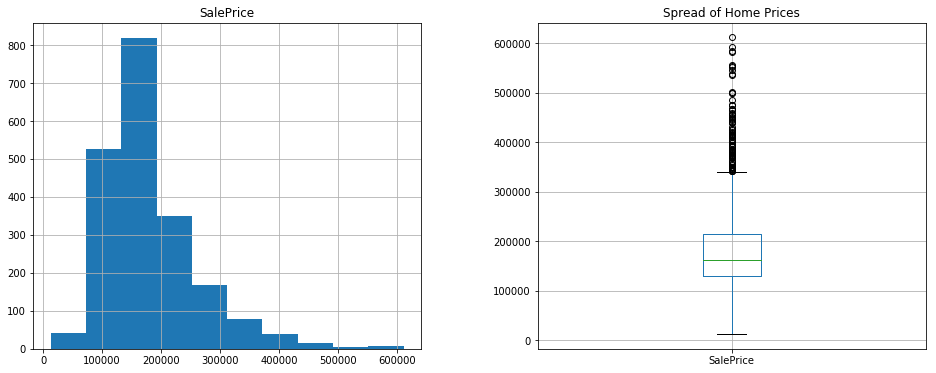

In [27]:
figure, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

df.hist('SalePrice', ax=ax[0])
plt.title('Distribution of Home Prices')
df.boxplot('SalePrice' )
plt.title('Spread of Home Prices')


Notice that the target variable, Sale Price, is not normally distributed. This means the errors will not be normally distributed either. I will need to standardize the values in the  training data in order to create a good model.

In [28]:
df.SalePrice.describe()

count      2051.000000
mean     181469.701609
std       79258.659352
min       12789.000000
25%      129825.000000
50%      162500.000000
75%      214000.000000
max      611657.000000
Name: SalePrice, dtype: float64

In [29]:
print(f"Median SalesPrice: {df.loc[:,'SalePrice'].median()}")

Median SalesPrice: 162500.0


The range of SalePrice is from around \$12K at the low end to just over \$600K at the high end. The mean is around \$181K, while the median is \$162K.

Select a subset of features to explore with a scatter plot

In [30]:
feature_list = ['Yr Sold', 'House Style', 'Condition 1', 'Bldg Type',  'BsmtFin Type 1', 'Garage Cond']

title_list = ['Year Sold', 'House Style', 'Condition', 'Building Type',  'Finished Basement', 'Garage Condition']

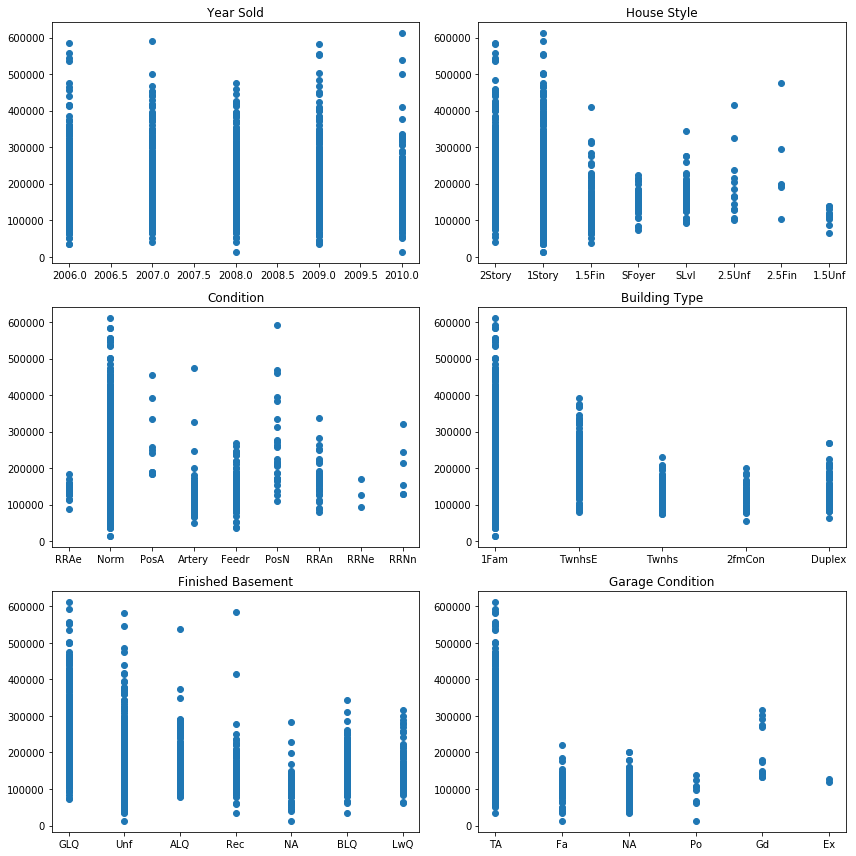

In [31]:
def subplot_scatter(dataframe, list_of_columns, list_of_titles, list_of_xlabels):
    nrows = int(np.ceil(len(list_of_columns)/2)) # Makes sure you have enough rows
    fig, ax = plt.subplots(nrows=nrows, ncols=2, figsize=(12,12))  
    ax = ax.ravel() # Ravel turns a matrix into a vector, which is easier to iterate
    for i, column in enumerate(list_of_columns): # Gives us an index value to get into all our lists
        ax[i].scatter(dataframe[column], dataframe['SalePrice']) # feel free to add more settings
        ax[i].set_title(list_of_titles[i])
    plt.tight_layout() #tip from Mark to keep x labels from overlapping the titles below
subplot_scatter(df, feature_list, title_list, feature_list)

## Correlation between the features and the Sale Price
I can look at a heatmat to visualize this all on one diagram.

In [32]:
bfdf = df.drop(columns=['Id','PID'])  #temp df used to plot without including the id columns
numeric_features = [col for col in bfdf._get_numeric_data().columns if col !='SalePrice']


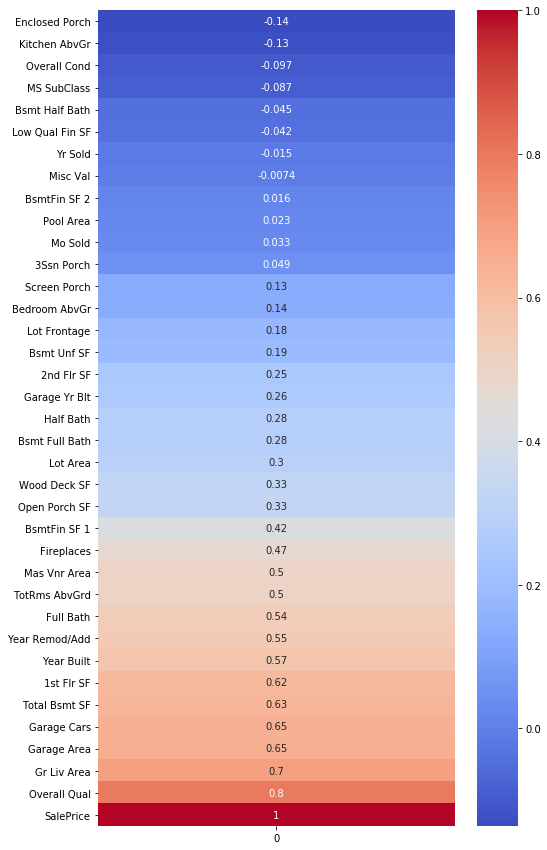

In [33]:
cw = bfdf.corrwith(bfdf['SalePrice'])

high_mask = cw[0] > .4
type(high_mask)
cw.describe()

cw = pd.DataFrame(cw)
high_mask = cw[0] > .001
low_mask = cw[0] < -.001
cw = cw[high_mask | low_mask]

plt.figure(figsize=(8, 15))
sns.heatmap(cw.sort_values(0), annot=True, cmap='coolwarm')

The heatmap shows a high positiove correlation with overall quality and above ground living, which is not surprising. What is surprising is a slight negative correlation with an enclosed porch and an above grade kitchen. 

I then looked at pairplots for each of the features, by data type, as opart of my analyzis. Rather than include them all, I did a few scatter plots to show those that did have a relationship with sales price. I left the code below so the lines could be uncommented and examined later. For the final project, though I am only going to incllude a fewl scatter plots of those features that do have a correlation. 

In [34]:
#These can be uncommented to look at pairplots by data type if desired
#sns.pairplot(bfdf, y_vars=numeric_features, x_vars='SalePrice');
#sns.pairplot(bfdf, y_vars=cols_i, x_vars='SalePrice');
#sns.pairplot(bfdf, y_vars=cols_f, x_vars='SalePrice');
#sns.pairplot(bfdf, y_vars=cols_o, x_vars='SalePrice');

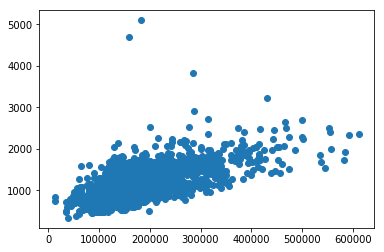

In [35]:
plt.scatter(df['SalePrice'], df['1st Flr SF'])

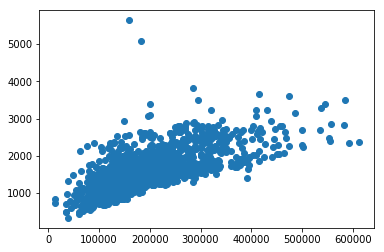

In [36]:
plt.scatter(df['SalePrice'], df['Gr Liv Area'])

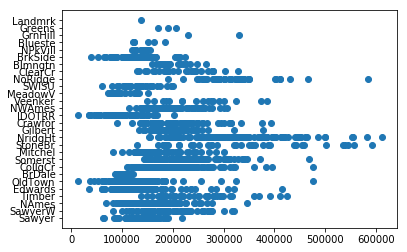

In [37]:
plt.scatter(df['SalePrice'], df['Neighborhood'])

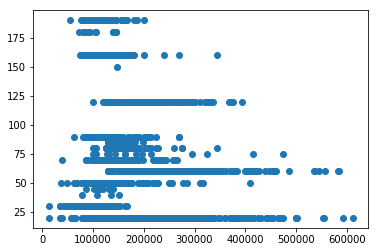

In [38]:
plt.scatter(df['SalePrice'], df['MS SubClass'])

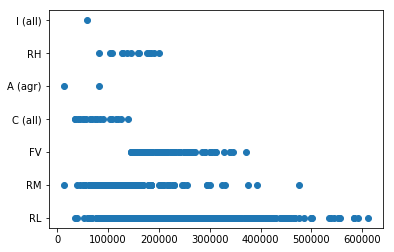

In [39]:
plt.scatter(df['SalePrice'], df['MS Zoning'])

After looking at the heatmap and scolling through the individual scatter plots, I noticed few pattern emerged.  

Correlations:
-  Quality - A number of features related to the quality of the home seemed to be correlated with sales price. As these correlations seemed to
-  Size - The size of the home seems to have an impact on price. It is represented in multiple features, such as overall living area, number of bedrooms on each floor, etc. 
-  Location - Neighborhood and zoning 
<br>
Strongest Predictors:
-  Overall Quality and Gr Living Area

It seems that many numeric columns may be collinear. I chose to leave them in my model, though, to see how they would be handled by the regularization step. 

#### Categorical Data
I tired adding  all categorical (oject types) data back into the dataset, using one-hot encoding to turn them into numerical data that could be modeled.

In [40]:
fdf = pd.get_dummies(df, drop_first=True)
fdf.head()

,Id,PID,MS SubClass,Lot Frontage,Lot Area,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Mas Vnr Area,...,Misc Feature_Shed,Misc Feature_TenC,Sale Type_CWD,Sale Type_Con,Sale Type_ConLD,Sale Type_ConLI,Sale Type_ConLw,Sale Type_New,Sale Type_Oth,Sale Type_WD
0,109,533352170,60,0.0,13517,6,8,1976,2005,289.0,...,0,0,0,0,0,0,0,0,0,1
1,544,531379050,60,43.0,11492,7,5,1996,1997,132.0,...,0,0,0,0,0,0,0,0,0,1
2,153,535304180,20,68.0,7922,5,7,1953,2007,0.0,...,0,0,0,0,0,0,0,0,0,1
3,318,916386060,60,73.0,9802,5,5,2006,2007,0.0,...,0,0,0,0,0,0,0,0,0,1
4,255,906425045,50,82.0,14235,6,8,1900,1993,0.0,...,0,0,0,0,0,0,0,0,0,1


In [41]:
tdf = pd.get_dummies(dftest, drop_first=True)
tdf.head()

,Id,PID,MS SubClass,Lot Frontage,Lot Area,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Mas Vnr Area,...,Misc Feature_Shed,Sale Type_CWD,Sale Type_Con,Sale Type_ConLD,Sale Type_ConLI,Sale Type_ConLw,Sale Type_New,Sale Type_Oth,Sale Type_VWD,Sale Type_WD
0,2658,902301120,190,69.0,9142,6,8,1910,1950,0.0,...,0,0,0,0,0,0,0,0,0,1
1,2718,905108090,90,0.0,9662,5,4,1977,1977,0.0,...,0,0,0,0,0,0,0,0,0,1
2,2414,528218130,60,58.0,17104,7,5,2006,2006,0.0,...,0,0,0,0,0,0,1,0,0,0
3,1989,902207150,30,60.0,8520,5,6,1923,2006,0.0,...,0,0,0,0,0,0,0,0,0,1
4,625,535105100,20,0.0,9500,6,5,1963,1963,247.0,...,0,0,0,0,0,0,0,0,0,1


In [42]:
X = fdf.drop(columns=['SalePrice'])
X.head()

y=df['SalePrice']

X_validate = pd.get_dummies(dftest, drop_first=True)

In [43]:
X.head()

,Id,PID,MS SubClass,Lot Frontage,Lot Area,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Mas Vnr Area,...,Misc Feature_Shed,Misc Feature_TenC,Sale Type_CWD,Sale Type_Con,Sale Type_ConLD,Sale Type_ConLI,Sale Type_ConLw,Sale Type_New,Sale Type_Oth,Sale Type_WD
0,109,533352170,60,0.0,13517,6,8,1976,2005,289.0,...,0,0,0,0,0,0,0,0,0,1
1,544,531379050,60,43.0,11492,7,5,1996,1997,132.0,...,0,0,0,0,0,0,0,0,0,1
2,153,535304180,20,68.0,7922,5,7,1953,2007,0.0,...,0,0,0,0,0,0,0,0,0,1
3,318,916386060,60,73.0,9802,5,5,2006,2007,0.0,...,0,0,0,0,0,0,0,0,0,1
4,255,906425045,50,82.0,14235,6,8,1900,1993,0.0,...,0,0,0,0,0,0,0,0,0,1


Applying get_dummies to both the training and the validation dataset resulted in files with different numbers of columns. This means that the category values are inconsistent between the two files. 
<br>
I wanted quick way to identify which columns already matched, and which ones would need to be cleaned before I could add them to my model. I wrote the following function to compare them and create a dictionary with column names as the keys and boolean values to indicate whether or not they matched. If True, I can use the feature as is. If False, it needs to be cleaned.



In [44]:
# #cSuggestd better way to do the below - from James Hampton
# train_columns = set(train_df.columns)
# test_columns = set(test_df.columns)
# train_columns - test_columns

In [45]:
#define a function that takes two data frames and a list of column names
# and checks to see if the values of categorical items are the same in two files
#Outputs a dictionary with each column name as the key 
#and a boolean value with True if they match, and false if they don't
def cat_check(df1, df2, col_name_list):
    col_match = {}
    for name in col_name_list:
        col_match[name] = sorted(  list(df1[name].unique())   ) == sorted(  list(df2[name].unique())   )
        
    return(col_match)
 


In [46]:
##Display the object columns as a reminder
cat_col_list = list(df.select_dtypes(include=['O']).columns)

cat_val_dict = cat_check(df, dftest, cat_col_list)
cat_val_dict



{'MS Zoning': False,
 'Street': True,
 'Alley': True,
 'Lot Shape': True,
 'Land Contour': True,
 'Utilities': False,
 'Lot Config': True,
 'Land Slope': True,
 'Neighborhood': False,
 'Condition 1': True,
 'Condition 2': False,
 'Bldg Type': True,
 'House Style': True,
 'Roof Style': True,
 'Roof Matl': False,
 'Exterior 1st': False,
 'Exterior 2nd': False,
 'Mas Vnr Type': False,
 'Exter Qual': True,
 'Exter Cond': True,
 'Foundation': True,
 'Bsmt Qual': True,
 'Bsmt Cond': False,
 'Bsmt Exposure': True,
 'BsmtFin Type 1': True,
 'BsmtFin Type 2': True,
 'Heating': False,
 'Heating QC': False,
 'Central Air': True,
 'Electrical': False,
 'Kitchen Qual': False,
 'Functional': False,
 'Fireplace Qu': True,
 'Garage Type': True,
 'Garage Finish': True,
 'Garage Qual': False,
 'Garage Cond': True,
 'Paved Drive': True,
 'Pool QC': False,
 'Fence': True,
 'Misc Feature': False,
 'Sale Type': False}

***
I see from the above there is a mismatch in the neighborhood column. Since this seems to be an important feature for testing whether location is really a good predictor of price, I need to explore this column and see what can be done to make it match in both files.  


Visual inspection revealed that two values for neighborhood, 'GrnHill' and 'Landmrk', are present in the training file but not in the test file.  
***

In [47]:
mask = (df['Neighborhood'] ==  'GrnHill') |  (df['Neighborhood'] ==  'Landmrk')
rows_to_drop = df[mask].index
#James Hampton also helped me get this to work without hard-coding the indices.

There are only three rows with values that do not have a match in the test file. I could explore a map of Ames to see if it is worth imputing the values, but since there are only three records, it is not likely to be worth the effort. For now I will eliminate those rows.

In [48]:
df.shape

(2051, 81)

In [49]:
df = df.drop(rows_to_drop)

In [50]:
df.shape   

(2048, 81)

Having fixed the neighborhood, I decided to select several other features that would not need to cleaned so I could proceed with modeling.

<br>
The features I chose were|
-  Neighborhood
-  BsmtFin Type 1 
-  Condition 1 
-  Bldg Type 
-  House Style 
-  Garage Cond
-  Paved Drive


Below I have defined a function that takes a dataframe and a list of categorical columns and returns an X dataframe of numeric features, concatonated with a one-hot encoded version of each of the categorical features passed in. The above checks make it easy to identify which columns can be successfully encoded and which ones will need to be cleaned before they can be added to the model. 


In [51]:
#Set features for first pass based on all numeric columns
feature_list_to_explore = ['Neighborhood', 'BsmtFin Type 1', 'Condition 1', 'Bldg Type', 'House Style', 'Garage Cond', 'Paved Drive']


In [52]:
def set_features_num_plus_cat(df, cat_features, final=False):
    num_features = [col for col in df._get_numeric_data().columns if col !='SalePrice']    
    #one-hot encode the categorical features
    #future: use pythonic methods
    
    #subset the input dataframe
    temp_data_frame = df[cat_features]
       
    #one-hot encode it to a temp called cat_coded_features
    cat_coded_features = pd.get_dummies(temp_data_frame, drop_first=True)
    
    #subset the num features
    numdf = df[num_features]
    
    #put them together
    X = pd.concat([numdf,cat_coded_features], axis = 1)
    
    #Exclude'Id' or 'PID' columns, not numeric in nature for the train set    
    if not final:
        X = X.drop(columns=['Id','PID'])
        
    return(X)
    

In [53]:
##Create a new X with the new features
X = set_features_num_plus_cat(df, feature_list_to_explore)
y = df['SalePrice']

Look at the first few rows to see that it is as expected.

In [54]:
X.head()

,MS SubClass,Lot Frontage,Lot Area,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Mas Vnr Area,BsmtFin SF 1,BsmtFin SF 2,...,House Style_2Story,House Style_SFoyer,House Style_SLvl,Garage Cond_Fa,Garage Cond_Gd,Garage Cond_NA,Garage Cond_Po,Garage Cond_TA,Paved Drive_P,Paved Drive_Y
0,60,0.0,13517,6,8,1976,2005,289.0,533.0,0.0,...,1,0,0,0,0,0,0,1,0,1
1,60,43.0,11492,7,5,1996,1997,132.0,637.0,0.0,...,1,0,0,0,0,0,0,1,0,1
2,20,68.0,7922,5,7,1953,2007,0.0,731.0,0.0,...,0,0,0,0,0,0,0,1,0,1
3,60,73.0,9802,5,5,2006,2007,0.0,0.0,0.0,...,1,0,0,0,0,0,0,1,0,1
4,50,82.0,14235,6,8,1900,1993,0.0,0.0,0.0,...,0,0,0,0,0,0,0,1,0,0


In [55]:
X.shape

(2048, 93)

The new dataset has 93 columns. Display the list to see the new names.

In [56]:
X.columns


Index(['MS SubClass', 'Lot Frontage', 'Lot Area', 'Overall Qual',
       'Overall Cond', 'Year Built', 'Year Remod/Add', 'Mas Vnr Area',
       'BsmtFin SF 1', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF',
       '1st Flr SF', '2nd Flr SF', 'Low Qual Fin SF', 'Gr Liv Area',
       'Bsmt Full Bath', 'Bsmt Half Bath', 'Full Bath', 'Half Bath',
       'Bedroom AbvGr', 'Kitchen AbvGr', 'TotRms AbvGrd', 'Fireplaces',
       'Garage Yr Blt', 'Garage Cars', 'Garage Area', 'Wood Deck SF',
       'Open Porch SF', 'Enclosed Porch', '3Ssn Porch', 'Screen Porch',
       'Pool Area', 'Misc Val', 'Mo Sold', 'Yr Sold', 'Neighborhood_Blueste',
       'Neighborhood_BrDale', 'Neighborhood_BrkSide', 'Neighborhood_ClearCr',
       'Neighborhood_CollgCr', 'Neighborhood_Crawfor', 'Neighborhood_Edwards',
       'Neighborhood_Gilbert', 'Neighborhood_Greens', 'Neighborhood_IDOTRR',
       'Neighborhood_MeadowV', 'Neighborhood_Mitchel', 'Neighborhood_NAmes',
       'Neighborhood_NPkVill', 'Neighborhood_NWAmes

***
X and y now look good. Now transform the test data
***

In [57]:
#Transforem the validation data. The dimensions will need to match when we test the model.
X_transformed = set_features_num_plus_cat(dftest, feature_list_to_explore, final=True)
   

In [58]:
X_transformed.shape

(879, 95)

The test file still contains the Id columns, so it is the expeted that it has two more columns than the training data at this point. I will remove them before modeling, but want to but want to preserve them in the saved file.

In [59]:
X.shape

(2048, 93)

<a id="section__Save_Cleaned_Data"></a>

## Save Cleaned Data
Saving tansformed data so it can be read it into another notbook for additional modeling,


[back to top](#section__top)


In [60]:
#save transformed validation data
X_transformed.to_csv('../data/validation_file.csv', index=False)

In [61]:
newtraindf = pd.concat([X,y], axis = 1)  #put these back together for saving to preserve order

In [62]:
newtraindf.shape


(2048, 94)

In [63]:
#save clean trained data
newtraindf.to_csv('../data/train_cleaned.csv', index=False)

<a id="section__Second_Model"></a>
### Second Linear Regression Model
Construct another linear regression model with these additional features, and compare it with the baseline


[back to top](#section__top)


In [64]:
X.shape, y.shape, X_transformed.shape

((2048, 93), (2048,), (879, 95))

In [65]:
X_transformed = X_transformed.drop(columns=['Id','PID'])
# Create train/test splits.
X_train, X_test, y_train, y_test = train_test_split(X,y, 
                                test_size=0.5, random_state=42) 

In [66]:
X.shape, y.shape, X_transformed.shape

((2048, 93), (2048,), (879, 93))

In [67]:
# Create train/test splits.
X_train, X_test, y_train, y_test = train_test_split(X,y, 
                                test_size=0.5, random_state=42)

# Note: this performed better on unscaled data
#Standardize the data so all features can be evaluated on the same scale.
# ss = StandardScaler()
# X_scaled = ss.fit_transform(X_train)


#Look at top rows of the scaled values to make sure they have been normalized
#X_scaled[:,:5]

In [68]:
#Peform the regression on the training split
mlr, beta0, beta1, r2score = try_mlr(X_train,y_train)
# print('mlr returns r2 score of {}'.format(r2score))
# print('mlr returns beta0 intercept {}'.format(beta0))
# print('mlr returns beta1 coefficients {}'.format(beta1))

##Score on the test split
print('R2 Score for Train Split {}'.format( mlr.score(X_train, y_train) ))
print('R2 Score for Test Split {}'.format( mlr.score(X_test, y_test) ))

R2 Score for Train Split 0.8829447013155689
R2 Score for Test Split 0.8413747523987042


Examine the coefficients of this model to see what features are contribute the most predictive value.

In [69]:

coef_df = pd.DataFrame(mlr.coef_, index=X.columns, columns=['coefficients'])
coef_df

coef_df['abs_coef'] = coef_df['coefficients'].abs()
coef_df

coef_df.sort_values(by='abs_coef', ascending=False, inplace=True)
coef_df.head()


,coefficients,abs_coef
Garage Cond_NA,128221.235330,128221.235330
Neighborhood_StoneBr,93914.591311,93914.591311
Neighborhood_NridgHt,57138.275914,57138.275914
House Style_2.5Unf,27065.247455,27065.247455
House Style_2.5Fin,-27009.253608,27009.253608


Though the r2 scores for this model are better, the beta0 intercept(-1275988.2256373537) and beta1 coefficients seem extreme. 
```
R2 Score for Train Split 0.8829447013155689
R2 Score for Test Split 0.8413747523987042
```
They also don't seem very explanative. It is hard to believe that having no garage is the stronges predictor. 

In [70]:
X.shape, y.shape, X_transformed.shape

((2048, 93), (2048,), (879, 93))

In [71]:
kaggle_preds = mlr.predict(X_transformed)

In [72]:
test_ids = pd.DataFrame(dftest.iloc[:,0])
preds = pd.DataFrame(kaggle_preds)

newdf = pd.concat([test_ids, preds], axis = 1)
newdf.rename(columns={0: 'SalePrice'}, inplace=True)
newdf.head()

,Id,SalePrice
0,2658,132966.472174
1,2718,144812.379180
2,2414,201167.781832
3,1989,105368.387429
4,625,201929.766307


In [73]:
#save file to upload
newdf.to_csv('../data/pred3.csv', index=False)

In [74]:
mlr_model_numcatfeat_pkl = open ('../models/lr_numcatfeat.csv', 'wb')
pickle.dump(mlr, mlr_model_numcatfeat_pkl)
mlr_model_numcatfeat_pkl.close()

<br>
I was able to beat my previous! Let's take a look closer look at the model values.

<br>

Do the assumptions of MLR hold? As a reminder, they are:

-  1. Linearity: 𝑌 must have an approximately linear relationship with each independent 𝑋𝑘.
-  2. Independence of Errors: Errors (residuals) 𝜀𝑖 and 𝜀𝑗 must be independent of one another for any 𝑖≠𝑗.
-  3. Normality: The errors (residuals) follow a Normal distribution with mean 0.
-  4. Equality of Variances: The errors (residuals) should have a roughly consistent pattern, regardless of the value of the 𝑋𝑘 predictors. (There should be no discernable relationship between the 𝑋 predictors and the residuals.)
-  5. Independence of Predictors: The independent variables 𝑋𝑘 and 𝑋𝑙 must be independent of one another for any 𝑘≠𝑙.
The mnemonic LINEI is a useful way to remember these five assumptions.
******

### Next steps... 

With the data cleaned and saved, we can go on to try some other modeling techniqes. See notebook 2. Modeling_and_results.